In [1]:
# !python -m venv comp_venv

In [2]:
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install seaborn
# !pip3 install matplotlib
# !pip3 install joblib
# !pip3 install scikit-learn
# !pip3 install sklearn
# !pip3 install keras
# !pip3 install pyswarm
# !pip3 install tensorflow
# !pip3 install setuptools
# !pip3 install h5py
# !pip3 install numpy==1.21.4
# !pip3 install pip install numba==0.53.0
# !pip3 install librosa
# !pip3 install openpyxl

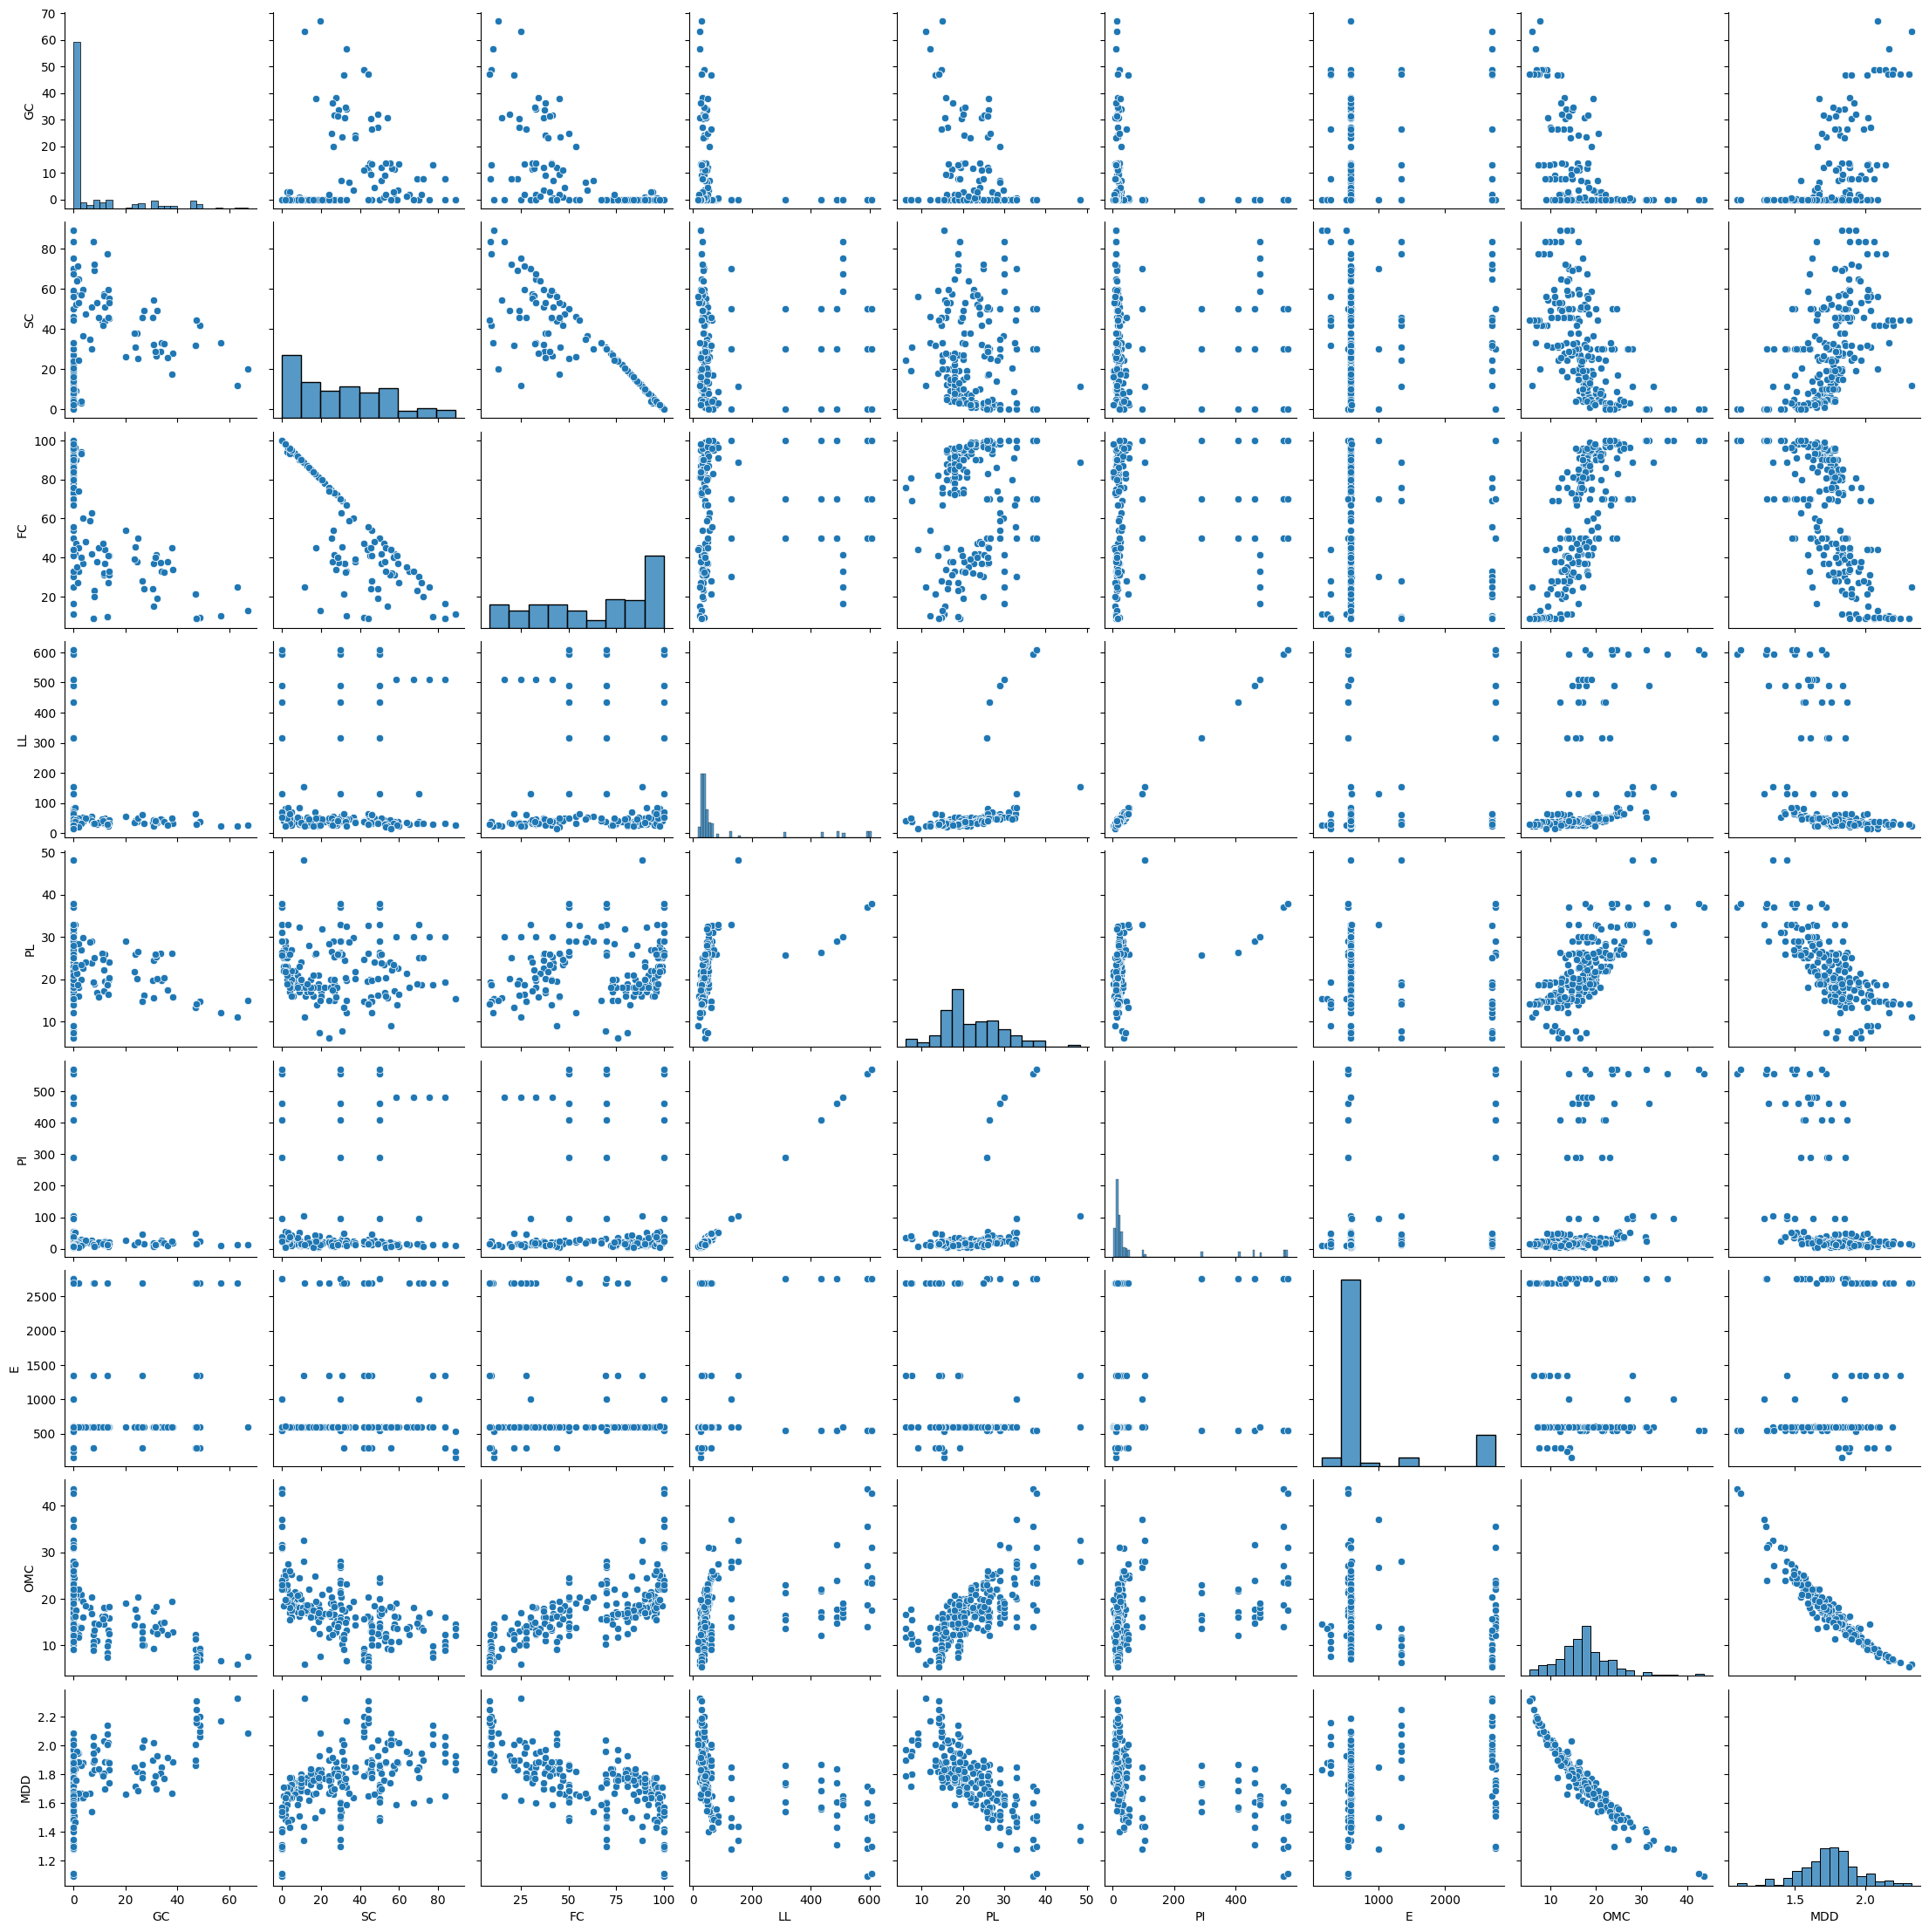

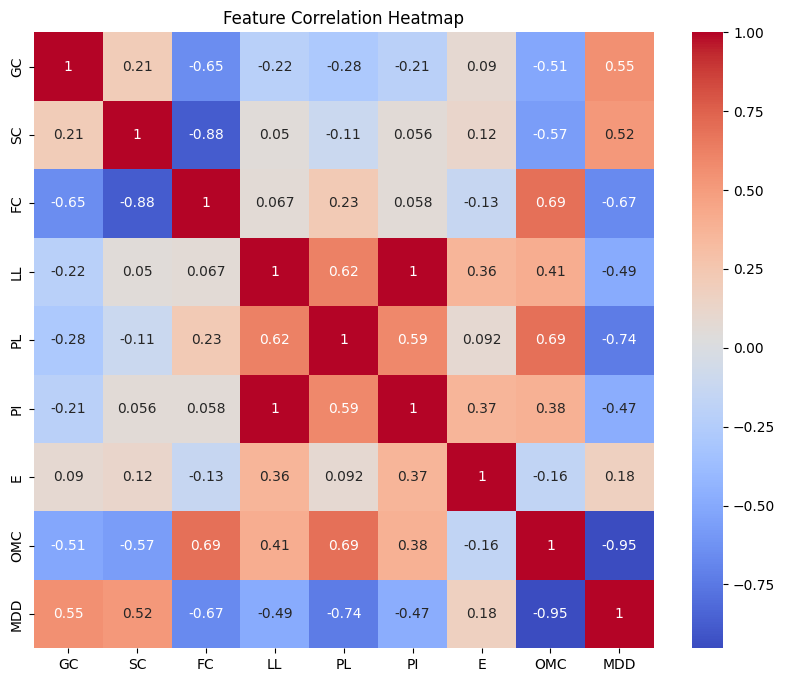

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# ------------------------
# Step 1: Load Dataset
# ------------------------
data = pd.read_excel("MDD-OMC.xlsx")  # Replace with your dataset path

# Ensure all columns in the dataset are numeric
data = data.apply(pd.to_numeric, errors="coerce")

# Handle missing values
data = data.fillna(data.mean())


# Create directories for results
os.makedirs("results/plots", exist_ok=True)
os.makedirs("results/models", exist_ok=True)

# Visualise Dataset
sns.pairplot(data)
plt.show()
plt.savefig("results/plots/dataset_pairplot.png")
plt.close()

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()
plt.savefig("results/plots/feature_correlation.png")
plt.close()

In [4]:
# ------------------------
# Step 2: Data Preparation
# ------------------------
X = data[["GC", "SC", "FC", "LL", "PL", "PI", "E"]]
y_omc = data["OMC"]
y_mdd = data["MDD"]

# Apply preprocessing (log-transform target variables to avoid negative predictions)
scaler_X = MinMaxScaler()
scaler_y = PowerTransformer()

X_scaled = scaler_X.fit_transform(X)
y_omc_scaled = scaler_y.fit_transform(y_omc.values.reshape(-1, 1)).flatten()
y_mdd_scaled = scaler_y.fit_transform(y_mdd.values.reshape(-1, 1)).flatten()

# Train-test split
X_train, X_test, y_train_omc, y_test_omc = train_test_split(X_scaled, y_omc_scaled, test_size=0.2, random_state=42)
X_train, X_test, y_train_mdd, y_test_mdd = train_test_split(X_scaled, y_mdd_scaled, test_size=0.2, random_state=42)


In [5]:
# ------------------------
# Step 3: Define Models and Hyperparameters
# ------------------------
models = {
    "Random Forest": (
        RandomForestRegressor(),
        {
            "n_estimators": [10, 50, 100, 200],
            "max_depth": [5, 10, 20, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    ),
    "Gradient Boosting": (
        GradientBoostingRegressor(),
        {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.7, 0.8, 0.9, 1.0],
        },
    ),
    "Support Vector Regression": (
        SVR(),
        {
            "C": [0.1, 1, 10, 100],
            "epsilon": [0.01, 0.1, 0.2, 0.5],
            "kernel": ["linear", "rbf"],
        },
    ),
    "Neural Network": (
        MLPRegressor(max_iter=1000),
        {
            "hidden_layer_sizes": [(10,), (20, 20), (40,)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01],
            "learning_rate": ["constant", "adaptive"],
        },
    ),
}

In [6]:
# ------------------------
# Step 4: Random Search Optimisation
# ------------------------
def random_search(model, params, X_train, y_train):
    random_search = RandomizedSearchCV(
        model,
        params,
        n_iter=50,
        cv=5,
        scoring="r2",
        random_state=42,
        n_jobs=-1,
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_


In [8]:
# ------------------------
# Step 5: Train and Evaluate Models
# ------------------------

def train_evaluate_save(models, X_train, X_test, y_train, y_test, target_variable):
    results = []

    for name, (model, params) in models.items():
        print(f"Optimising {name} for {target_variable}...")
        best_model, best_params = random_search(model, params, X_train, y_train)

        # Save the individual best model
        model_path = f"results/models/{target_variable}_{name}_best.pkl"
        joblib.dump(best_model, model_path)

        # Predict and back-transform
        y_pred_train = scaler_y.inverse_transform(best_model.predict(X_train).reshape(-1, 1)).flatten()
        y_pred_test = scaler_y.inverse_transform(best_model.predict(X_test).reshape(-1, 1)).flatten()
        y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

        # Metrics
        r2_train = r2_score(y_train_orig, y_pred_train)
        r2_test = r2_score(y_test_orig, y_pred_test)
        mse_train = mean_squared_error(y_train_orig, y_pred_train)
        mse_test = mean_squared_error(y_test_orig, y_pred_test)

        results.append({
            "model": name,
            "r2_train": r2_train,
            "r2_test": r2_test,
            "mse_train": mse_train,
            "mse_test": mse_test,
            "best_params": best_params,
        })

        # Save predictions plot as grid (Training and Testing side by side)
        fig, axes = plt.subplots(1, 2, figsize=(7, 3))

        # Training plot
        axes[0].scatter(y_train_orig, y_pred_train, alpha=0.7, color="blue")
        axes[0].plot([y_train_orig.min(), y_train_orig.max()], [y_train_orig.min(), y_train_orig.max()], color="red", lw=2)
        axes[0].set_title(f"{name} - Training ({target_variable})")
        axes[0].set_xlabel("Actual Values")
        axes[0].set_ylabel("Predicted Values")

        # Testing plot
        axes[1].scatter(y_test_orig, y_pred_test, alpha=0.7, color="blue")
        axes[1].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], color="red", lw=2)
        axes[1].set_title(f"{name} - Testing ({target_variable})")
        axes[1].set_xlabel("Actual Values")
        axes[1].set_ylabel("Predicted Values")

        # Adjust layout and save
        fig.tight_layout()
        plt.show()
        plot_path = f"results/plots/{target_variable}_{name}_grid_predictions.png"
        plt.savefig(plot_path)
        plt.close()
        print(f"Saved grid plot for {name} at {plot_path}")

    # Compare performance
    compare_model_performance(results, target_variable)

    # Select the best model based on R²
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"results/{target_variable}_metrics.csv", index=False)
    best_model_row = results_df.loc[results_df["r2_test"].idxmax()]
    print(f"Best model for {target_variable}: {best_model_row['model']}")
    return results_df


# Comparison Performance (already in code, unchanged)
def compare_model_performance(metrics, target_variable):
    """
    Compare model performance using bar charts for R² and MSE scores.
    """
    model_names = [m['model'] for m in metrics]
    r2_train = [m['r2_train'] for m in metrics]
    r2_test = [m['r2_test'] for m in metrics]
    mse_train = [m['mse_train'] for m in metrics]
    mse_test = [m['mse_test'] for m in metrics]

    x = np.arange(len(model_names))
    width = 0.35

    # R² Score Comparison
    plt.figure(figsize=(8, 6))
    plt.bar(x - width / 2, r2_train, width, label='Train R²', color='blue', alpha=0.7)
    plt.bar(x + width / 2, r2_test, width, label='Test R²', color='orange', alpha=0.7)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xticks(x, model_names, rotation=45)
    plt.xlabel("Models")
    plt.ylabel("R² Score")
    plt.title(f"R² Score Comparison: {target_variable}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(f"results/plots/{target_variable}_r2_comparison.png")
    plt.close()

    # MSE Comparison
    plt.figure(figsize=(8, 6))
    plt.bar(x - width / 2, mse_train, width, label='Train MSE', color='blue', alpha=0.7)
    plt.bar(x + width / 2, mse_test, width, label='Test MSE', color='orange', alpha=0.7)
    plt.xticks(x, model_names, rotation=45)
    plt.xlabel("Models")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Mean Squared Error Comparison: {target_variable}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(f"results/plots/{target_variable}_mse_comparison.png")
    plt.close()



Training models for Optimum Moisture Content (OMC):
Optimising Random Forest for OMC...


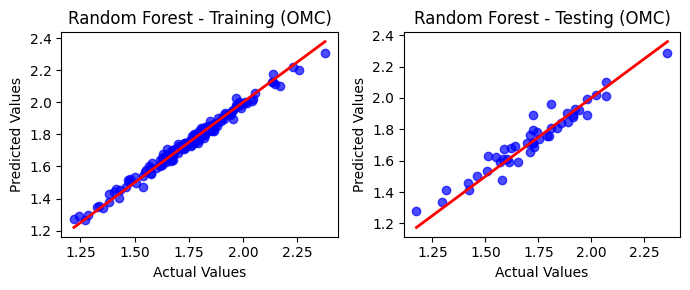

Saved grid plot for Random Forest at results/plots2/OMC_Random Forest_grid_predictions.png
Optimising Gradient Boosting for OMC...


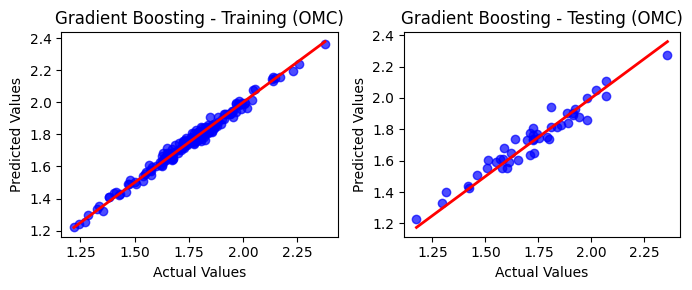

Saved grid plot for Gradient Boosting at results/plots2/OMC_Gradient Boosting_grid_predictions.png
Optimising Support Vector Regression for OMC...


e:\01_Personal Gigs\00_Repository\01_MDD_OMC\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


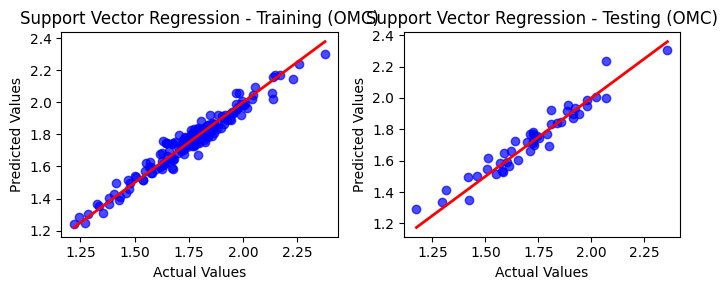

Saved grid plot for Support Vector Regression at results/plots2/OMC_Support Vector Regression_grid_predictions.png
Optimising Neural Network for OMC...


e:\01_Personal Gigs\00_Repository\01_MDD_OMC\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


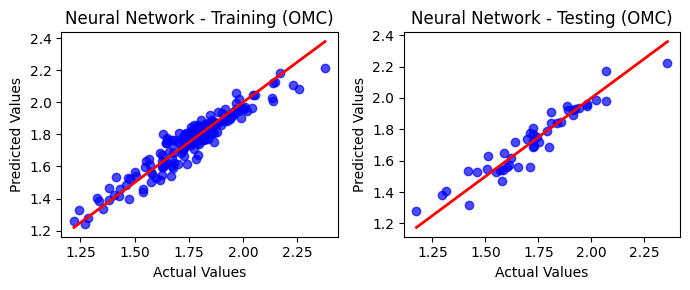

Saved grid plot for Neural Network at results/plots2/OMC_Neural Network_grid_predictions.png


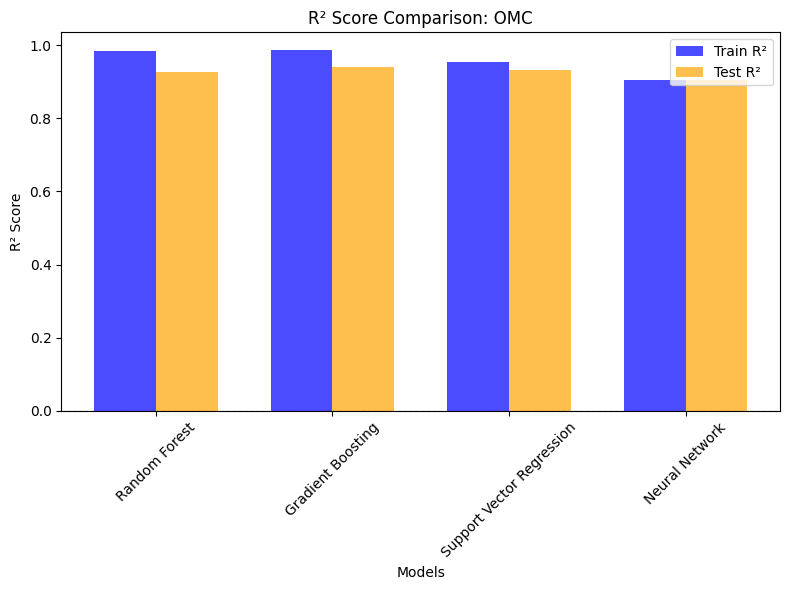

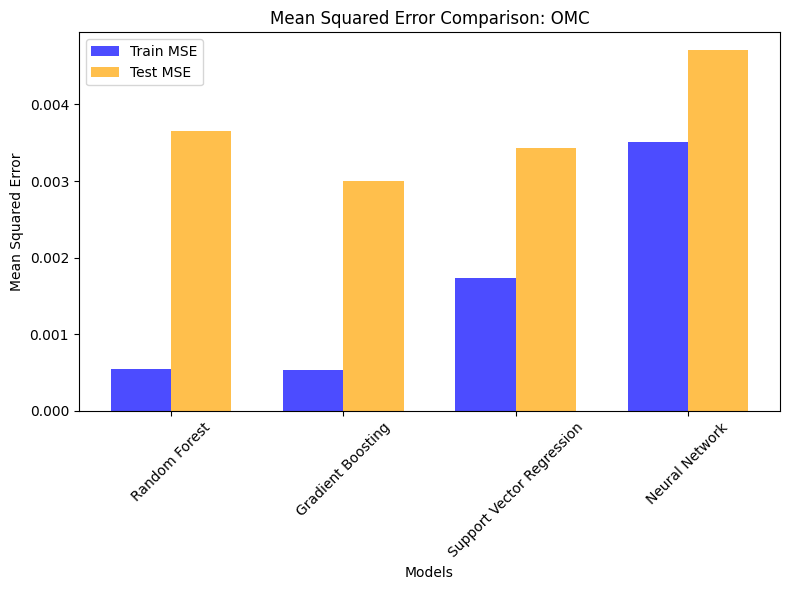

Best model for OMC: Gradient Boosting

Training models for Maximum Dry Density (MDD):
Optimising Random Forest for MDD...


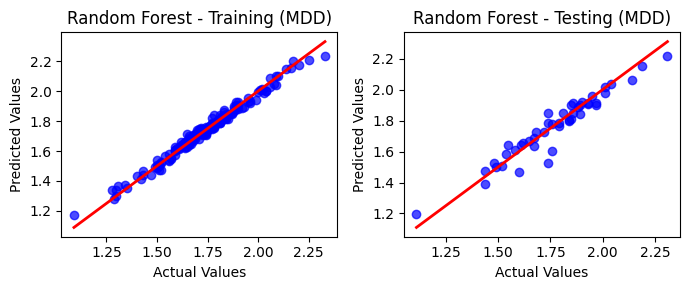

Saved grid plot for Random Forest at results/plots2/MDD_Random Forest_grid_predictions.png
Optimising Gradient Boosting for MDD...


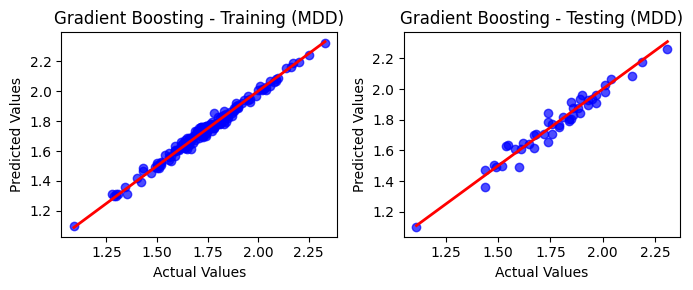

Saved grid plot for Gradient Boosting at results/plots2/MDD_Gradient Boosting_grid_predictions.png
Optimising Support Vector Regression for MDD...


e:\01_Personal Gigs\00_Repository\01_MDD_OMC\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


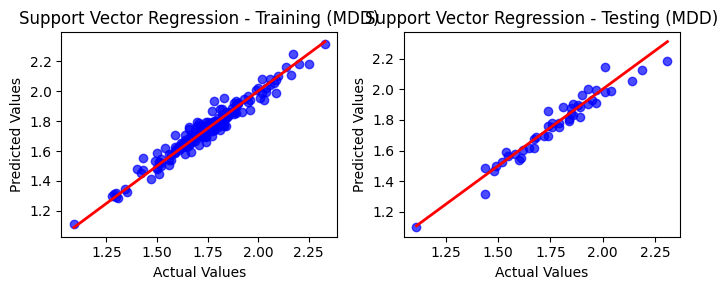

Saved grid plot for Support Vector Regression at results/plots2/MDD_Support Vector Regression_grid_predictions.png
Optimising Neural Network for MDD...


e:\01_Personal Gigs\00_Repository\01_MDD_OMC\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


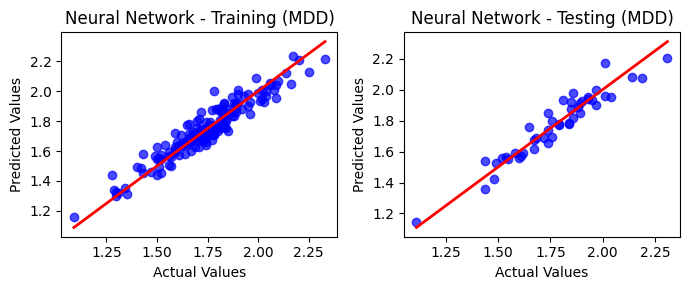

Saved grid plot for Neural Network at results/plots2/MDD_Neural Network_grid_predictions.png


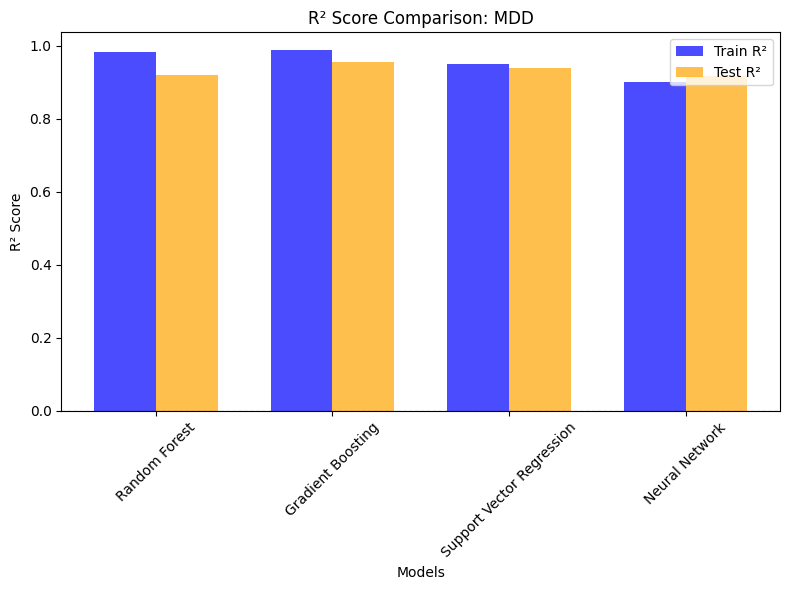

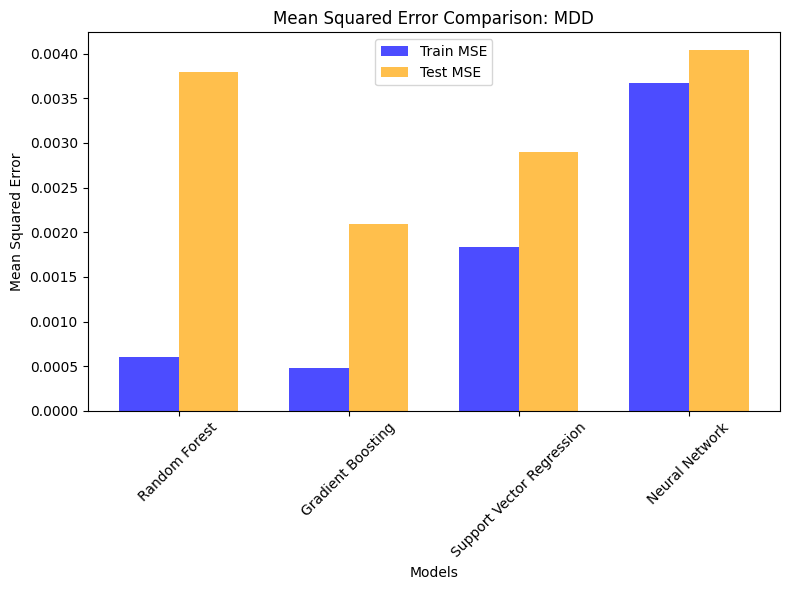

Best model for MDD: Gradient Boosting


In [9]:
# ------------------------
# Step 6: Execute for OMC and MDD
# ------------------------
os.makedirs("results/plots", exist_ok=True)

print("\nTraining models for Optimum Moisture Content (OMC):")
results_omc = train_evaluate_save(models, X_train, X_test, y_train_omc, y_test_omc, "OMC")

print("\nTraining models for Maximum Dry Density (MDD):")
results_mdd = train_evaluate_save(models, X_train, X_test, y_train_mdd, y_test_mdd, "MDD")